In [92]:
# Installed scikit-video (skvideo) and ffmpeg from conda
# https://anaconda.org/conda-forge/sk-video
# https://anaconda.org/conda-forge/ffmpeg

import skvideo.io
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from skimage.measure import label, regionprops
from skimage import morphology
from skimage.color import label2rgb
from skimage.exposure import histogram
from skimage.feature import canny
from skimage.filters import sobel
from skimage.segmentation import watershed

from ipywidgets import interact

# skvideo can either use vread or vreader
# vreader uses a generator (loads frames on-demand to save memory)

# If file is avi:
file_name = 'laser.mp4'
frames = skvideo.io.vread(file_name, as_grey = True)

# Check the size of the loaded data
frames.shape

(200, 500, 1024, 1)

Inspect the data and perform a background correction

In [84]:
def frame_generator(frames, frame_number, background = 19, cropv = (105, 300), croph = (None, None), takelog = True):
    image = frames[frame_number].squeeze() + 0.01 # Add 0.01 to avoid zero division
    background = frames[background].squeeze() + 0.01
    if takelog == True:
        image = np.log(image) - np.log(background) # Subtract background
    else:
        image = image - background
    image = image[cropv[0]:cropv[1], croph[0]:croph[1]] # Crop image if necessary
    return image

In [47]:
def frame_plotter(frames, frame_number, background = 19, cropv = (105, 300), croph = (None, None)):
    image = frame_generator(frames, frame_number, background, cropv, croph)

    # Plot the image
    fig, axes = plt.subplots(1, 1, figsize = (15,10))
    im1 = axes.imshow(image)
    fig.colorbar(im1, shrink = 0.2)
    plt.show()

Find a good background frame with interactive plot

In [48]:
@interact
def show_frame(frame_number=(0, len(frames)-1, 1), background = (0, len(frames)-1, 1)):
    frame_plotter(frames, frame_number, background=background, cropv = (None, None))


interactive(children=(IntSlider(value=99, description='frame_number', max=199), IntSlider(value=99, descriptio…

https://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html reference for some of this code

Test to see if thresholding is sufficient to segment

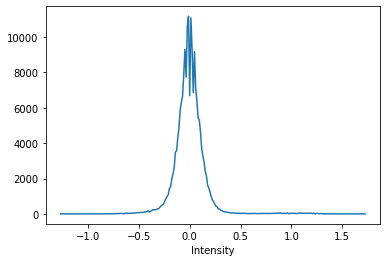

In [63]:
# Plot the intensity histogram
image = frame_generator(frames, 181, background = 19, cropv = (105, 300), croph = (None, None))
hist, hist_centers = histogram(image)
plt.plot(hist_centers, hist)
plt.xlabel('Intensity')
plt.show()

In [73]:
@interact
def thresholding(th_low = (-0.7, 0.7, 0.1), th_high = (-0.7, 0.7, 0.1)):
    markers = np.zeros_like(image)
    markers[image < th_low] = 1
    markers[image > th_high] = 2

    plt.figure(figsize = (15,10))
    plt.imshow(markers)
    plt.colorbar(shrink = 0.2)

interactive(children=(FloatSlider(value=-0.09999999999999987, description='th_low', max=0.7, min=-0.7), FloatS…

Test edge-based segmentation

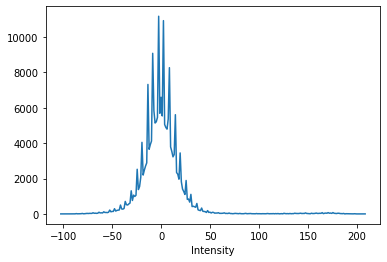

In [100]:
# Generate non-log image
image = frame_generator(frames, 181, background = 19, cropv = (105, 300), croph = (None, None), takelog = False)
# Plot the intensity histogram
hist, hist_centers = histogram(image)
plt.plot(hist_centers, hist)
plt.xlabel('Intensity')
plt.show()

In [88]:
@interact
def canny_detect(factor = (0, 1000, 1), fill = (0, 1, 1)):
    edges = canny(image/factor)
    if fill:
        edges = ndi.binary_fill_holes(edges)
    plt.figure(figsize = (15,10))
    plt.imshow(edges)
    # plt.colorbar(shrink = 0.2)

interactive(children=(IntSlider(value=500, description='factor', max=1000), IntSlider(value=0, description='fi…

Test gradient-based segmentation

In [136]:
@interact(
    frame_number = (0, len(frames)-1, 1), 
    th_low = (-70, 70, 1), 
    th_high = (-70, 70, 1), 
    segmentation = True, 
    fill = True, 
    original = True,
    opacity = (0, 1, 0.1),
    remove_small = True,
    min_size = (0, 20, 1))

def thresholding(
        frame_number = 181, 
        th_low = -40, 
        th_high = 40, 
        segmentation = True, 
        fill = True, 
        original = True,
        opacity = 1,
        remove_small = True, 
        min_size = 10):
    image = frame_generator(frames, frame_number, background = 19, cropv = (105, 300), croph = (None, None), takelog = False)
    markers = np.zeros_like(sobel(image))
    markers[image < th_low] = 2
    markers[image > th_high] = 1
    out = markers
    if segmentation:
        out = watershed(sobel(image), markers)
    if fill:
        out = ndi.binary_fill_holes(out-1)
    if remove_small:
        out = morphology.remove_small_objects(out, min_size=min_size)
    
    plt.figure(figsize = (15,10))
    if original:
        plt.imshow(image)
    plt.imshow(out, alpha = opacity)
    plt.colorbar(shrink = 0.2)

interactive(children=(IntSlider(value=181, description='frame_number', max=199), IntSlider(value=-40, descript…

Labelling with ndi.label() works by assigning each pixel a label value, try e.g. labeled[50]

the labeled object can then be processed with e.g. morphology.remove_small_objects, which works on pixel area

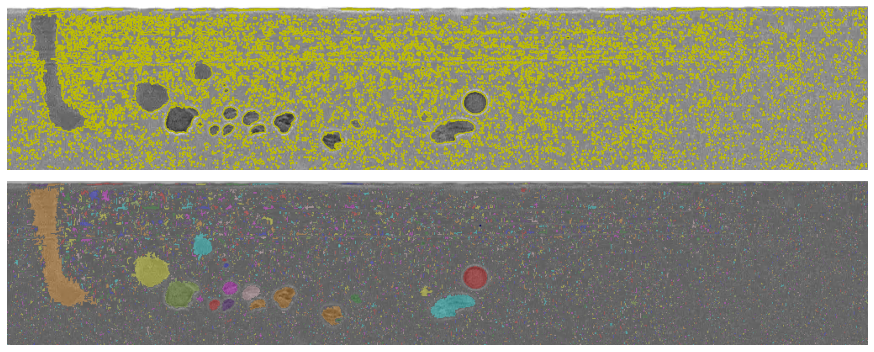

In [45]:
segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled, image=image, bg_label=0)

fig, axes = plt.subplots(2, 1, figsize=(15, 5), sharey=True)
axes[0].imshow(image, cmap=plt.cm.gray)
axes[0].contour(segmentation, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay)

for a in axes:
    a.axis('off')

plt.tight_layout()

plt.show()

In [54]:
for i in regionprops(labeled):
    print(i.area)

59
33
9
2
4
3
8
11
2
6
3
2
1
1
1
37
4016
2
4
3
4
8
22
2
39
2
2
38
11
2
1
4
1
1
1
4
1
1
1
1
1
2
3
2
32
2
16
6
1
2
2
3
1
3
2
5
2
2
1
2
1
1
1
1
7
5
1
1
1
5
1
5
2
1
1
3
1
3
2
5
1
2
1
1
6
1
1
2
1
1
2
1
17
1
1
2
1
1
1
1
1
1
1
1
1
1
2
2
2
2
20
1
3
1
2
1
2
1
1
1
1
1
1
1
1
2
3
1
7
1
1
1
1
2
2
1
1
3
1
4
2
1
1
2
1
2
1
2
1
10
1
1
8
1
1
1
2
4
11
4
2
1
4
1
1
1
1
2
1
1
1
1
1
1
1
2
2
1
3
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
2
1
1
27
95
3
76
1
20
1
1
1
1
1
3
3
2
5
2
1
1
1
1
1
2
2
1
4
1
2
1
1
1
1
2
1
2
1
1
2
1
2
1
2
1
1
1
1
1
1
1
3
1
1
1
3
2
1
5
2
1
4
1
1
1
2
2
1
1
3
2
3
1
1
11
2
3
1
2
17
17
9
2
4
6
1
2
1
1
4
1
5
4
3
1
2
1
1
1
4
4
2
1
1
1
2
1
2
2
9
9
1
1
1
1
1
2
2
2
2
4
1
1
2
4
1
1
2
1
11
1
3
3
37
3
8
8
1
1
1
15
1
3
4
3
2
1
2
1
3
1
1
1
2
2
1
2
1
4
3
3
1
1
1
1
2
11
44
10
7
2
5
1
4
14
1
1
1
6
2
13
3
2
1
1
1
1
1
4
1
1
1
12
1
1
1
2
3
4
1
1
1
1
2
1
1
1
1
1
1
2
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
4
1
4
1
2
1
1
6
2
4
1
1
1
3
1
1
6
1
1
1
1
2
1
3
1
8
2
2
1
1
1
5
1
1
1
1
1
1
1
1
2
3
1
1
1
2
1
3
1
1
4
1
1
1
1
1
1
19


In [55]:
# Remove small artifacts - size of the vials is ~4000
labeled_clean = morphology.remove_small_objects(labeled, 10)
regions = regionprops(labeled_clean)


for i in regions:
#     print(i.area)
    print(i.centroid)

(3.2711864406779663, 115.83050847457628)
(2.8181818181818183, 409.57575757575756)
(2.3636363636363638, 826.0)
(4.54054054054054, 38.891891891891895)
(79.94546812749005, 55.0343625498008)
(3.5, 230.45454545454547)
(3.641025641025641, 272.0)
(3.1842105263157894, 305.86842105263156)
(3.1818181818181817, 427.72727272727275)
(3.65625, 804.9375)
(3.0625, 840.625)
(8.647058823529411, 64.76470588235294)
(10.3, 613.75)
(11.7, 158.1)
(11.363636363636363, 269.72727272727275)
(13.185185185185185, 91.55555555555556)
(16.778947368421054, 103.43157894736842)
(17.592105263157894, 116.63157894736842)
(13.95, 123.4)
(14.0, 135.45454545454547)
(14.352941176470589, 165.23529411764707)
(16.705882352941178, 170.7058823529412)
(14.818181818181818, 147.0909090909091)
(17.972972972972972, 184.27027027027026)
(14.6, 426.93333333333334)
(15.727272727272727, 66.63636363636364)
(19.204545454545453, 71.52272727272727)
(15.4, 83.3)
(16.428571428571427, 203.64285714285714)
(17.23076923076923, 277.2307692307692)
(15.5

Write these centroids by scatter plot

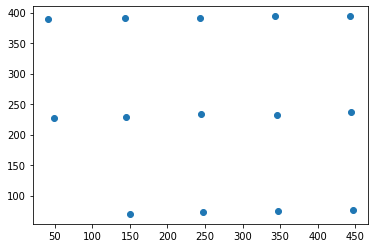

In [11]:
# Append centroids to list
# Note - zip(*[list]) makes zip work in reverse - tuple to lists rather than list to tuples

centroids = [i.centroid for i in regions]
x, y = zip(*[(i[1], i[0]) for i in centroids])

plt.scatter(x, y)

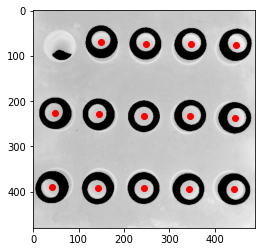

In [12]:
fig, axes = plt.subplots()
axes.imshow(image, cmap=plt.cm.gray)
axes.scatter(x,y, color='r')

Alternative approach: erode labelled regions
https://forum.image.sc/t/shrink-labeled-regions/50443/10

In [13]:
# https://forum.image.sc/t/shrink-labeled-regions/50443/10

def erode_labels(segmentation, erosion_iterations):
    from scipy import ndimage
    # create empty list where the eroded masks can be saved to
    list_of_eroded_masks = list()
    regions = regionprops(segmentation)
    def erode_mask(segmentation_labels, label_id, erosion_iterations):
        
        only_current_label_id = np.where(segmentation_labels == label_id, 1, 0)
        eroded = ndimage.binary_erosion(only_current_label_id, iterations = erosion_iterations)
        relabeled_eroded = np.where(eroded == 1, label_id, 0)
        return(relabeled_eroded)

    for i in range(len(regions)):
        label_id = regions[i].label
        list_of_eroded_masks.append(erode_mask(segmentation, label_id, erosion_iterations))

    # convert list of numpy arrays to stacked numpy array
    final_array = np.stack(list_of_eroded_masks)

    # max_IP to reduce the stack of arrays, each containing one labelled region, to a single 2D np array. 
    final_array_labelled = np.sum(final_array, axis = 0)
    return(final_array_labelled)

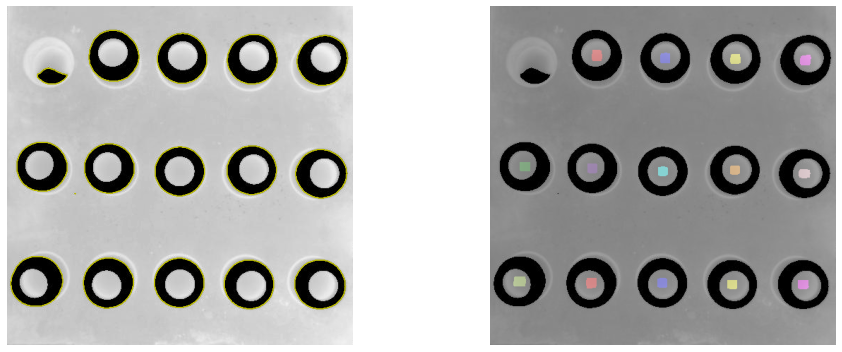

In [14]:
# segmentation = ndi.binary_fill_holes(segmentation - 1)
# labeled, _ = ndi.label(segmentation)

labeled_eroded = erode_labels(labeled, 28)
image_label_overlay = label2rgb(labeled_eroded, image=image, bg_label=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
axes[0].imshow(image, cmap=plt.cm.gray)
axes[0].contour(segmentation, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay)

for a in axes:
    a.axis('off')

# Add label numbers
# for i in regions:
#     plt.text(int(i.centroid[1]), int(i.centroid[0]), i.label, c = 'w', fontweight = 'bold')
    
plt.tight_layout()
plt.show()

In [15]:
# Remember to include the 'intensity_image' parameter
regions = regionprops(labeled_eroded, intensity_image = image)

for i in regions:
#     print(i.mean_intensity)
    print(i.area)

221
197
196
209
194
191
174
181
193
236
210
188
178
192


In [16]:
frames.squeeze().shape

(1250, 480, 640)

In [17]:
# Read out all of the regions' time series
# Remember to crop intensity image if necessary

temps = []

for i in frames.squeeze():
    regions = regionprops(labeled_eroded, intensity_image = i[:, crop[0]:crop[1]])
    temps.append([i.mean_intensity for i in regions])

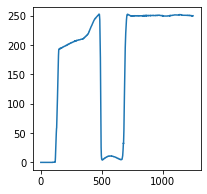

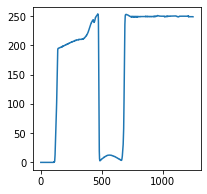

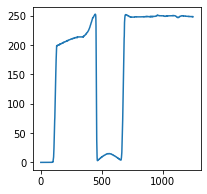

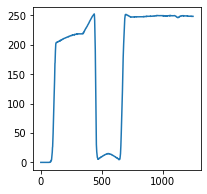

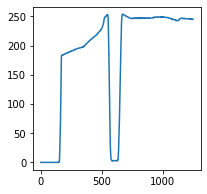

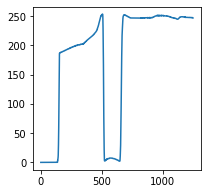

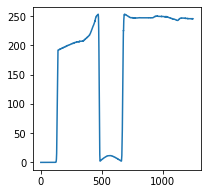

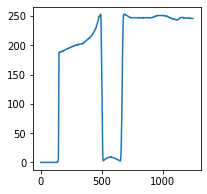

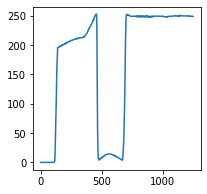

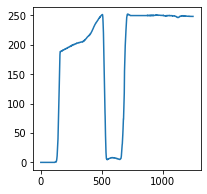

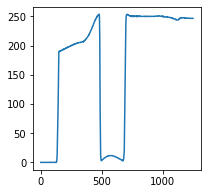

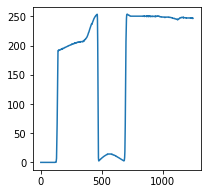

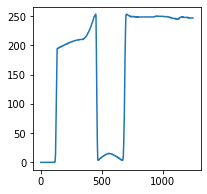

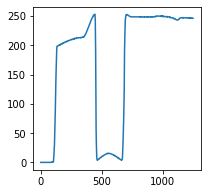

In [18]:
for j in range(len(regions)):
    x = [i[j] for i in temps]
    plt.figure(figsize=(3,3))
    plt.plot(x)
    plt.show()